In [481]:
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
import ssm
from ssm.util import find_permutation

from src.models.hmm import HistogramHMM
from src.data.experiment_data import ExperimentData
from src.features.fit_curves import get_sigmoid_feats
from src.features.losses import mse_loss
from run import run_switching_experiment

from src.features.fit_curves import epsilon_sigmoid
from src.visualization.plot_replications import plot_fitted_block, plot_sigmoids

from ssm.plots import gradient_cmap, white_to_color_cmap
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")
color_names = [
    "light navy",
    
    "marigold",
    "dusty purple",
    "orange",
    "windows blue",
    "marigold",
    ]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [200]:
states = np.column_stack((expt_data.agent_labels, expt_data.parameter_labels))
np.argwhere(np.all(states == np.array([0, 0.01, 0.01]), axis=1)).shape
print(expt_data.sigmoid_parameters.shape)

(1000000, 3)


### Generate histograms for HistogramHMM

In [300]:
expt_name = "generate_ssm_histogram"
repo_path = "/Users/johnzhou/research/decision-making"
expt_data = ExperimentData(expt_name, repo_path)
boundary = list(expt_data.agent_labels == 1).index(True)

In [301]:
offset_bins = list(range(-1, 15))
mf_hist, mf_bins = np.histogramdd(expt_data.sigmoid_parameters[:boundary, :], bins=[100, 100, offset_bins])
mb_hist, mb_bins = np.histogramdd(expt_data.sigmoid_parameters[boundary:, :], bins=[100, 100, offset_bins])
emission_hists = [mf_hist / np.sum(mf_hist), mb_hist / np.sum(mb_hist)]
emission_bins = [mf_bins, mb_bins]

### Generate sequential data

In [460]:
from typing import Tuple
from tqdm import tqdm

transmat = np.array([[0.7, 0.3],
                    [0.3, 0.7]])

def run_sampling_switching_experiment(transition_matrix,
                                      expt_data,
                                      lr_bounds: Tuple[float, float] = (0.01, 1.4),
                                      eps_bounds: Tuple[float, float] = (0.01, 0.5),
                                      num_lrs: int = 25,
                                      num_eps: int = 20,
                                      pswitch_bounds: Tuple[float, float] = (0.01, 0.45),
                                      prew_bounds: Tuple[float, float] = (0.55, 0.99),
                                      num_pswitches: int = 25,
                                      num_prews: int = 20,
                                      true_pr_rew: float = 1.0,
                                      trial_range: Tuple[int, int] = (15, 25),
                                      num_blocks: int = 220):
    state_history = np.zeros(num_blocks, dtype=int)
    sigmoid_params = np.zeros((num_blocks, 3))
    strat = np.random.randint(2)
    for block_idx in tqdm(range(num_blocks)):
        rand = np.random.rand()
        if rand >= transition_matrix[strat, strat]:
            strat = 1 - strat
        state_history[block_idx] = int(strat)
        if strat == 0:
            p1_bounds = lr_bounds
            num_p1 = num_lrs
            p2_bounds = eps_bounds
            num_p2 = num_eps
        elif strat == 1:
            p1_bounds = pswitch_bounds
            num_p1 = num_pswitches
            p2_bounds = prew_bounds
            num_p2 = num_prews
        else:
            raise ValueError
        p1_idx = np.random.randint(num_p1)
        p1 = np.linspace(p1_bounds[0], p1_bounds[1], num=num_p1)[p1_idx]
        p2_idx = np.random.randint(num_p2)
        p2 = np.linspace(p2_bounds[0], p2_bounds[1], num=num_p2)[p2_idx]
        
        states = np.column_stack((expt_data.agent_labels, expt_data.parameter_labels))
        matched_idxs = np.argwhere(np.all(states == np.array([strat, p1, p2]), axis=1)).flatten()
        sampled_idx = matched_idxs[np.random.randint(matched_idxs.size)]
        sigmoid_params[block_idx, :] = expt_data.sigmoid_parameters[sampled_idx, :]
    return state_history, sigmoid_params

time_bins =300
true_states, X = run_sampling_switching_experiment(transmat, expt_data, num_blocks=time_bins)

100%|███████████████████████████████████████████████████| 300/300 [00:12<00:00, 24.94it/s]


In [461]:
true_states = true_states[X.shape[0]//2:]
X_train = X[:X.shape[0]//2, ...]
X_test = X[X.shape[0]//2:, ...]

In [462]:
print(true_states)

[1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0
 1 1 1 1 1 1 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0
 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0
 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0]


## Fit SSMs

### Fit HistogramHMM

In [463]:
scores = []
models = []

hist_model = HistogramHMM(2, 3, emission_hists, emission_bins, random_state=idx)
hist_model.fit(X_train)  # 50/50 train/validate
print(f'Converged: {hist_model.monitor_.converged}'
      f'\tScore: {hist_model.score(X_test)}')

hist_predicted_states = hist_model.predict(X_test)
print(hist_predicted_states)
print(hist_model.transmat_)

/Users/johnzhou/research/decision-making/src/models/hmm.py:102: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


Converged: True	Score: -488.63109674475976
[1 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0
 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0
 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0
 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0]
[[0.72749404 0.27250596]
 [0.17252785 0.82747215]]


/Users/johnzhou/research/decision-making/src/models/hmm.py:102: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)
/Users/johnzhou/research/decision-making/src/models/hmm.py:102: RuntimeWarning: divide by zero encountered in log
  return np.log(probs)


### Fit GaussianHMM

In [464]:
scores = []
models = []

for idx in range(10):
    # define our hidden Markov model
    model = GaussianHMM(n_components=2,
                            covariance_type='full',
                            random_state=idx)
    model.fit(X_train)  # 50/50 train/validate
    models.append(model)
    scores.append(model.score(X_train))
    print(f'Converged: {model.monitor_.converged}'
          f'\tScore: {scores[-1]}')

model = models[np.argmax(scores)]
n_states = model.n_components
print(f'The best model had a score of {max(scores)} and {n_states} '
      'states')
predicted_states = model.predict(X_test)
print(predicted_states)

Converged: True	Score: 279.2444226524226
Converged: True	Score: 286.0485690714223
Converged: True	Score: -191.1745534997363
Converged: True	Score: 316.5089998905218
Converged: True	Score: 324.1874212260808
Converged: True	Score: -167.043240680868
Converged: True	Score: -191.57426965212602
Converged: True	Score: -191.86703334394426
Converged: True	Score: 320.39365318296535
Converged: True	Score: 321.5857575521114
The best model had a score of 324.1874212260808 and 2 states
[0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1
 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


### Fit Gaussian HMM from SSM library

In [465]:
num_states = 2
obs_dim = 3
obs_model = "gaussian"
N_iters = 1000
fit_method = "em"

hmm = ssm.HMM(num_states, obs_dim, observations=obs_model) 
hmm_lls = hmm.fit(X_train, method=fit_method, num_em_iters=N_iters, init_method="kmeans")

most_likely_states = hmm.most_likely_states(X_test)
print(true_states.shape)
print(most_likely_states.shape)
hmm.permute(find_permutation(true_states, most_likely_states))
hmm_z = hmm.most_likely_states(X_test)

LP: -191.4: 100%|██████████████████████████████████████| 100/100 [00:00<00:00, 160.90it/s]


(150,)
(150,)


## Plot results

0.6666666666666667
0.94
0.7466666666666666


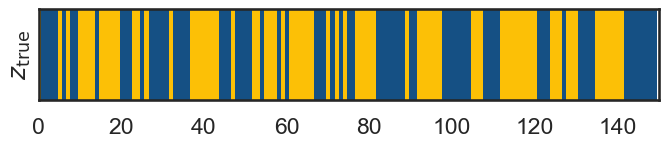

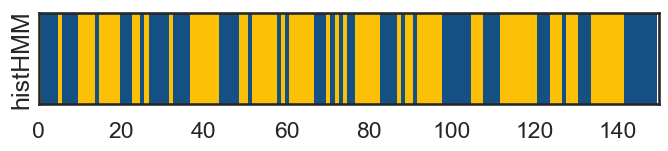

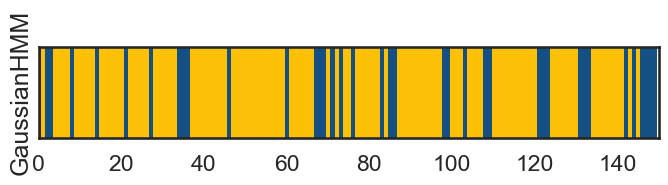

In [485]:
time_bins = X.shape[0]//2
plt.figure(figsize=(8, 4))
plt.subplot(311)
plt.imshow(true_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])

score = 1 - np.mean(np.abs(predicted_states - true_states))
if score < 0.5:
    predicted_states = 1 - predicted_states
    print(1 - score)
else:
    print(score)
plt.savefig(f'/Users/johnzhou/Desktop/sim_True.eps', format='eps')

# plt.figure(figsize=(8, 4))
# plt.subplot(412)
# plt.imshow(predicted_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
# plt.xlim(0, time_bins)
# plt.ylabel("HMMLearn")
# plt.yticks([])
score = 1 - np.mean(np.abs(hist_predicted_states - true_states))
if score < 0.5:
    hist_predicted_states = 1 - hist_predicted_states
    print(1 - score)
else:
    print(score)
plt.figure(figsize=(8, 4))
plt.subplot(312)
plt.imshow(hist_predicted_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("histHMM")
plt.yticks([])
plt.savefig(f'/Users/johnzhou/Desktop/sim_HistHMM.eps', format='eps')

print(1 - np.mean(np.abs(hmm_z - true_states)))
plt.figure(figsize=(8, 4))
plt.subplot(313)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, time_bins)
plt.ylabel("GaussianHMM")
plt.yticks([])


# score = 1 - np.mean(np.abs(hist_predicted_states - true_states))
# if score < 0.5:
#     hist_predicted_states = 1 - hist_predicted_states
#     print(1 - score)
# else:
#     print(score)
# plt.figure(figsize=(8, 4))
# plt.subplot(414)
# plt.imshow(hist_predicted_states[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
# plt.xlim(0, time_bins)
# plt.ylabel("histHMM")
# plt.yticks([])

plt.savefig(f'/Users/johnzhou/Desktop/sim_GaussHMM.eps', format='eps')

## Plot regime states

In [467]:
X_test = X[X.shape[0]//2:]

In [468]:
def visualize_sigmoids(sigmoid_params, idxs):
    params_list = sigmoid_params[idxs.flatten(), ...]
    plot_sigmoids(epsilon_sigmoid, params_list)

In [469]:
def visualize_regimes(state_preds, sigmoid_params):
    plt.figure()
    plt.subplot(211)
    idxs_0 = np.argwhere(state_preds == 0)
    visualize_sigmoids(sigmoid_params, idxs_0)
    plt.figure()
    plt.subplot(212)
    idxs_1 = np.argwhere(state_preds == 1)
    visualize_sigmoids(sigmoid_params, idxs_1)

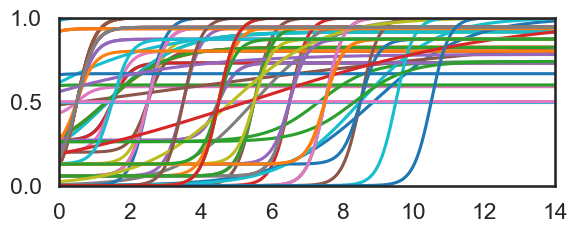

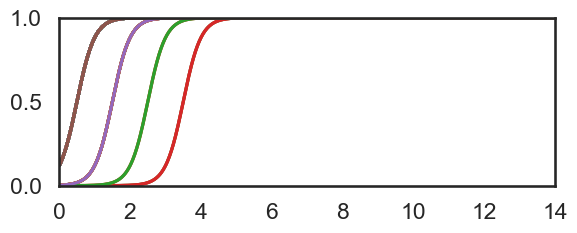

In [490]:
state_preds = true_states
sigmoid_params = np.squeeze(X_test)

xlim = (0, 14)
ylim = (0, 1)
num_samples = 1000
plt.figure()
plt.subplot(211)
idxs_0 = np.argwhere(state_preds == 0)
params_list = sigmoid_params[idxs_0.flatten(), ...]
if type(params_list) is np.ndarray:
    if params_list.ndim == 1:
        params_list = [params_list]
    elif params_list.ndim > 2:
        raise ValueError("Params should be of shape (num_samples, block_length).")
else:
    if type(params_list[0]) != list or type(params_list[0]) != ndarray:
        params_list = [params_list]

for params in params_list:
    plt.plot(np.linspace(*xlim, num=num_samples),
             epsilon_sigmoid(np.linspace(*xlim, num=num_samples), *params))
plt.xlim(xlim)
plt.ylim(ylim)
plt.savefig(f'/Users/johnzhou/Desktop/overlaps_mf.eps', format='eps')

plt.figure()
plt.subplot(212)
idxs_1 = np.argwhere(state_preds == 1)
params_list = sigmoid_params[idxs_1.flatten(), ...]
if type(params_list) is np.ndarray:
    if params_list.ndim == 1:
        params_list = [params_list]
    elif params_list.ndim > 2:
        raise ValueError("Params should be of shape (num_samples, block_length).")
else:
    if type(params_list[0]) != list or type(params_list[0]) != ndarray:
        params_list = [params_list]

for params in params_list:
    plt.plot(np.linspace(*xlim, num=num_samples),
             epsilon_sigmoid(np.linspace(*xlim, num=num_samples), *params))
plt.xlim(xlim)
plt.ylim(ylim)
plt.savefig(f'/Users/johnzhou/Desktop/overlaps_mb.eps', format='eps')

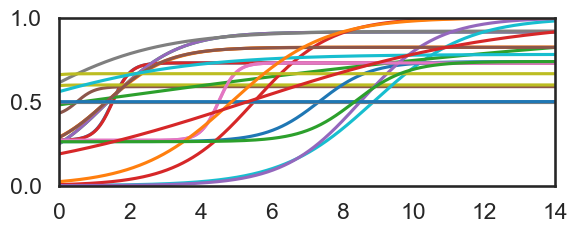

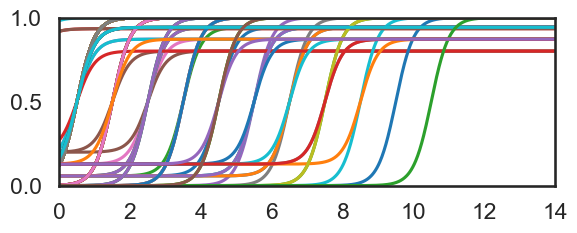

In [471]:
visualize_regimes(predicted_states, np.squeeze(X_test))

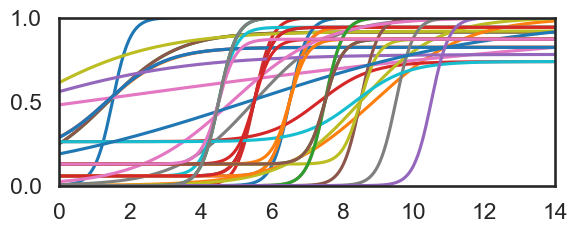

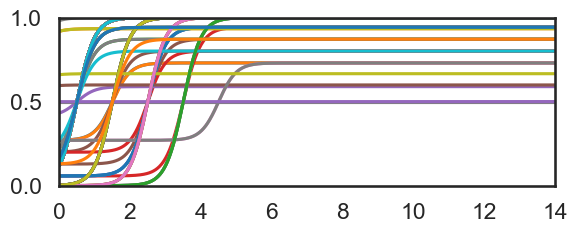

In [472]:
visualize_regimes(hmm_z, np.squeeze(X_test))

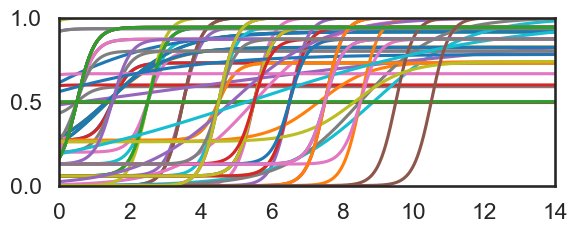

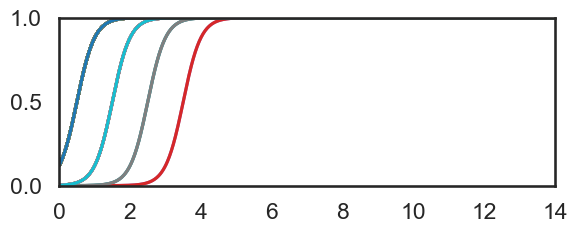

In [473]:
visualize_regimes(hist_predicted_states, np.squeeze(X_test))

In [474]:
hist_model.transmat_

array([[0.72749404, 0.27250596],
       [0.17252785, 0.82747215]])

[[0.7 0.3]
 [0.3 0.7]]
[[0.72749404 0.27250596]
 [0.17252785 0.82747215]]


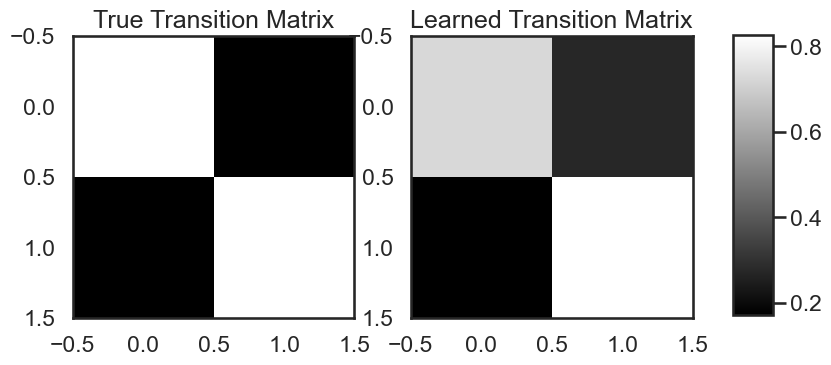

In [475]:
true_transition_mat = transmat
learned_transition_mat = hist_model.transmat_
print(true_transition_mat)
print(learned_transition_mat)

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()